# National Stock Exchange Kenya (NSE) Prediction using Linear Regression
This notebook describes the process of predicting stock exchange prices of Diamond Trust Bank company using Linear Regression. The specific algorithm to be used is Gradient Descent.

Linear regression assumes a linear or straight line relationship between the input variables (X) and the single output variable (y).([Machine Learning Mastery](https://machinelearningmastery.com/implement-simple-linear-regression-scratch-python/))

The data is scraped from the official [NSE Kenya Website](https://www.nse.co.ke/market-statistics.html). The scraping is done by a simple python script worker deployed on Heroku. The scraper then stores this data into a Google Spreadsheets document. This notebook thus gets the data from that Spreadsheet for use in the analysis

First, import the necessary modules:

In [3]:
import csv
import math
import pandas as pd
import numpy as np

from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression
from spreadsheet import GoogleSpreadSheets

### Preparing the data

In [4]:
sheets = GoogleSpreadSheets("NSE Stocks", "DTK")

In [5]:
dtk_data = sheets.get_all_records(head=2)

Let's convert the data into csv format for better handling

In [6]:
keys = dtk_data[0].keys()
with open('dtk_stocks.csv', 'wb') as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(dtk_data)

In [7]:
dtk_stocks = pd.read_csv('dtk_stocks.csv')
print dtk_stocks.shape
dtk_stocks.head()

(19, 8)


,company,volume,last_traded_price_ksh,percentage_change,date,prev_price_ksh,low_ksh,high_ksh
0,Diamond Trust Bank Kenya Ltd Ord 4.00,1500.0,190,-0.52,Thu Nov 16 22:58:11 2017,191,190,190
1,Diamond Trust Bank Kenya Ltd Ord 4.00,24300.0,187,-1.58,Fri Nov 17 22:38:53 2017,190,186,190
2,Diamond Trust Bank Kenya Ltd Ord 4.00,32100.0,190,NaN,Mon Nov 20 11:01:00 2017,190,190,190
3,Diamond Trust Bank Kenya Ltd Ord 4.00,32100.0,190,1.60,Tue Nov 21 15:01:15 2017,187,186,191
4,Diamond Trust Bank Kenya Ltd Ord 4.00,400.0,175,NaN,Mon Oct 23 11:01:00 2017,175,175,175


Prepare features that affect the last traded price / closing price

In [8]:
# Percent volatility ((high - close)/close) * 100
dtk_stocks['HIGH_LOW_PERCENT'] = ((dtk_stocks['high_ksh'] - dtk_stocks['last_traded_price_ksh'])/dtk_stocks['last_traded_price_ksh'] * 100)

# Daily percent change / Daily move ((new - old)/old)*100
dtk_stocks['DAILY_PERCENT_CHANGE'] = ((dtk_stocks['last_traded_price_ksh'] - dtk_stocks['prev_price_ksh'])/dtk_stocks['prev_price_ksh'] * 100)

Filter out columns / features that will not be used

In [11]:
features = ['prev_price_ksh', 'last_traded_price_ksh']
dtk_stocks = dtk_stocks[features]
dtk_stocks.head()

,prev_price_ksh,last_traded_price_ksh
4,175,175
5,175,175
6,175,178
7,178,178
8,178,179


In [13]:
forecast_feature = 'last_traded_price_ksh' #  The column to be predicted by the model

# Drop data that is not defined
dtk_stocks.dropna()
dtk_stocks.head()

,prev_price_ksh,last_traded_price_ksh
4,175,175
5,175,175
6,175,178
7,178,178
8,178,179


Features will be defined as uppercase X and labels as lowercase y

In [14]:
X = np.array(dtk_stocks.drop(['last_traded_price_ksh'], axis=1)) # Drop the 'last_traded_price_ksh' feature. Returns a new dataframe
y = np.array(dtk_stocks['last_traded_price_ksh'])

Now, scale / normalize the data to fit `-1` to `1` values

In [16]:
X = preprocessing.scale(X)
y = preprocessing.scale(y)
print len(X), len(y) # Check to see if the lengths are equal

print X, y

19 19
[[-1.55514175]
 [-1.55514175]
 [-1.55514175]
 [-1.02114729]
 [-1.02114729]
 [-0.66515099]
 [-0.66515099]
 [-0.48715284]
 [ 0.04684162]
 [ 0.22483977]
 [ 0.40283792]
 [ 0.58083607]
 [ 0.75883423]
 [ 1.29282868]
 [ 1.29282868]
 [ 1.11483053]
 [ 1.11483053]
 [ 0.58083607]
 [ 1.11483053]] [-1.75987647 -1.75987647 -1.19632052 -1.19632052 -1.00846854 -0.82061656
 -0.63276457 -0.06920863  0.11864336  0.30649534  0.49434732  0.68219931
  0.87005129  1.24575526  1.05790327  0.49434732  1.05790327  1.05790327
  1.05790327]


### Scatterplot of the dataset

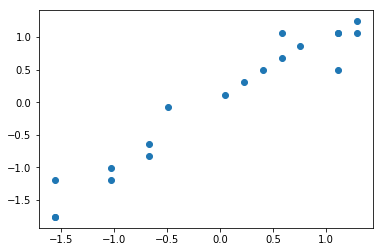

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(X, y);

### Defining the model (creating the functions)
`y = c + m * x`

Where `c` is the y intercept, and `m` is the gradient

#### Mini-Batch Gradient Descent Algorithm
The Mini-batch algorithm performs a parameter update for each set of training examples

Start with random values of `m` and `c`, then calculate prediction error using the Sum of Squared Errors method.
The SSE formula:

SSE = `1/2((y - y_prediction)^2)`

Let:
`m = 0.3` and `c = 0.2`

Also, define a learning rate to use.

In [36]:
# Random values for m and c, and a learning rate
m = 0.3
c = 0.2
learning_rate = 0.01

# Test values
# a = [0.00, 0.22, 0.24, 0.33, 0.37, 0.44, 0.44, 0.57, 0.93, 1.00]
# b = [0.00, 0.22, 0.58, 0.20, 0.55, 0.39, 0.54, 0.53, 1.00, 0.61]

def regression_model(m, c, x_value):
    return (m * x_value) + c

def calculate_y_predictions(m, c, x_values):
    return [regression_model(m, c, value) for value in x_values]

# Function to calculate sum of squared errors
def calculate_sse(y, y_predictions):
    return [0.5 * ((value[0] - value[1])**2) for value in zip(y, y_predictions)]
    


[0.45, 0.615, 0.63, 0.6975, 0.7275, 0.78, 0.78, 0.8775, 1.1475, 1.2]


0.670175

Calculate the error gradients with regard to the weights.

For m (the gradient):

`-(y - y_prediction) * X`

For b:

`-(y - y_prediction)`


In [43]:
def get_m_gradients(y_values, y_predictions, x_values):
    return [((-1 * (value[0] - value[1])) * value[2]) for value in zip(y_values, y_predictions, x_values)]

def get_c_gradients(y, y_predictions):
    return [(-1 * (value[0] - value[1])) for value in zip(y, y_predictions)]

# m_gradients = get_m_gradients(y, y_predictions, m)
# c_gradients = get_c_gradients(y, y_predictions)

# print "M Gradients: ", m_gradients, "\nC gradients: ", c_gradients

1.5312

Adjust the weights with the gradients to reach the optimal values where SSE is minimized

Update the random values of m and c in the direction that is optimal

In [45]:
def get_new_equation_value(current_value, learning_rate, gradient_sum):
    return current_value - (learning_rate * gradient_sum)

# Update m and c
# m = get_new_equation_value(m, learning_rate, sum(m_gradients))
# c = get_new_equation_value(c, learning_rate, sum(c_gradients))

0.41700000000000004

### Running the Algorithm and adjusting the values

Put it all together in an iterative function.
The stopping condition? After 1000 epochs

In [63]:
# X.flatten()
def gradient_descent_runner(x_values, y_values, m, c, learning_rate, epoch=1000):
    errors = []
    m_c_values = [(m,c)]
    for i in range(10):
        
        # Calculate y predictions using the initial m and c values for the equation
        y_predictions = calculate_y_predictions(m, c, x_values)
        sse_values = calculate_sse(y_values, y_predictions) 
        total_sse = sum(sse_values)
        errors.append(total_sse)
        
        # Calculate error gradients with regard to the weights
        m_gradients = get_m_gradients(y_values, y_predictions, x_values)
        c_gradients = get_c_gradients(y_values, y_predictions)
        
        # Adjust the weights with the gradients to reach the optimal values where SSE is minimized
        m = get_new_equation_value(m, learning_rate, sum(m_gradients))
        c = get_new_equation_value(c, learning_rate, sum(c_gradients))
        m_c_values.append((m,c))

    return m, c, errors

m, c, errors = gradient_descent_runner(X.flatten(), y, m, c, learning_rate, 10000)
print "M: ", m, "\nC: ", c
       


M:  0.959509614736 
C:  0.00295617658829


Thus, the Regression Line Formula:

```
y = 0.959509614736 (X) + 0.00295617658829
```


In [64]:
# def regression_model(m, c, x_value):
#     return (m * x_value) + c
    

X_flat = X.flatten()
# print X_flat[0]
y_predictions = calculate_y_predictions(m, c, X_flat)
    

#### Plot Regression line

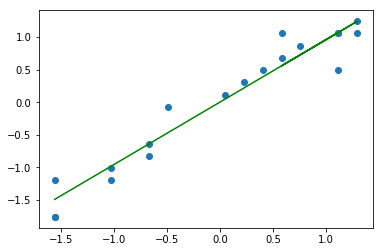

In [65]:
import matplotlib.pyplot as plt
m, c = np.polyfit(X.flatten(), y_predictions, 1)
plt.scatter(X, y);
plt.plot(X, m*X + c, 'g-')

#### The Cost function error plot

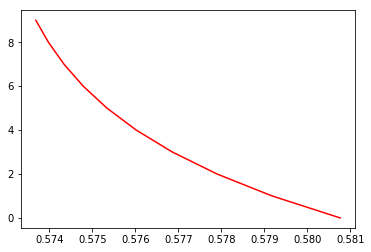

In [61]:
plt.plot(errors, range(0, len(errors)), 'r-')